In [136]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional

""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.
    
"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module,
                          input_image: Image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1], visualization.shape[0]))
            results.append(visualization)
        return [batch_results, results]
    
    
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")
dataset = load_dataset("cats_vs_dogs", revision="main")
image = dataset["train"]["image"][30]
img_tensor = transforms.ToTensor()(image)

Found cached dataset cats_vs_dogs (/home/amir/.cache/huggingface/datasets/cats_vs_dogs/default/1.0.0/d4fe9cf31b294ed8639aa58f7d8ee13fe189011837038ed9a774fde19a911fcb)
100%|██████████| 1/1 [00:00<00:00, 511.38it/s]


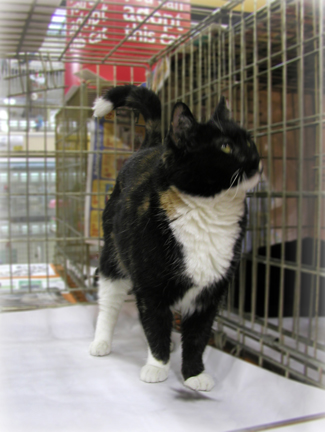

In [94]:
image

In [160]:
from transformers import AutoImageProcessor, ViTForImageClassification
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0], 12, 12, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

## dive into reshape transform

model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384')
processor = AutoImageProcessor.from_pretrained('google/vit-large-patch32-384')
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "Siamese cat, Siamese"))]
target_layer_dff = model.vit.layernorm
target_layer_gradcam = model.vit.encoder.layer[-2].output

inputs_tensor = processor(images=image, return_tensors="pt")
inputs_np = processor(images=image, return_tensors="np")

image_resized = image.resize((384, 384))
# tensor_resized = transforms.ToTensor()(image_resized)

print_top_categories(model, inputs_tensor.pixel_values[0])

Predicted class 285: Egyptian cat
Predicted class 282: tiger cat
Predicted class 281: tabby, tabby cat
Predicted class 283: Persian cat
Predicted class 332: Angora, Angora rabbit


In [144]:
res = run_grad_cam_on_image(model=model,
                      target_layer=target_layer_gradcam,
                      targets_for_gradcam=targets_for_gradcam,
                      input_tensor=inputs_tensor.pixel_values[0], #tensor_resized,
                      input_image=image_resized,
                      reshape_transform=reshape_transform_vit_huggingface)

RuntimeError: shape '[2, 12, 12, 1024]' is invalid for input of size 1179648

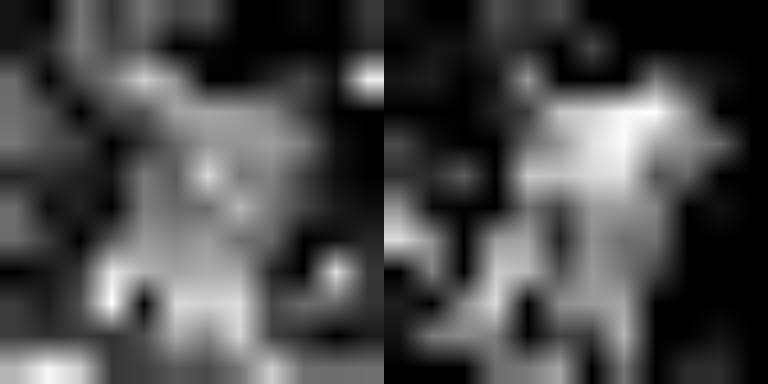

In [139]:
grayscales = np.uint8(res[0] * 255)
Image.fromarray(np.hstack(grayscales))

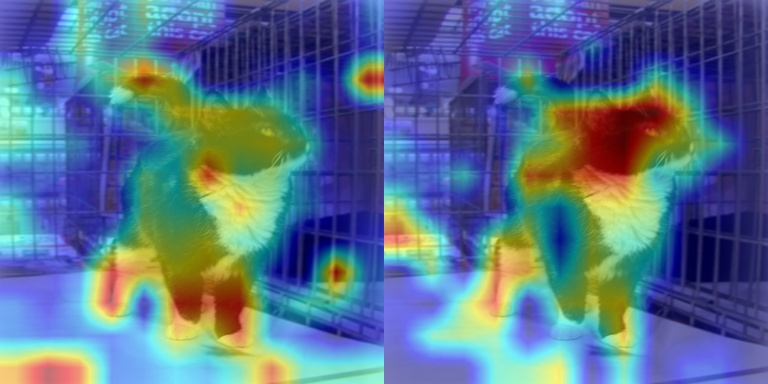

In [140]:
Image.fromarray(np.hstack(res[1]))

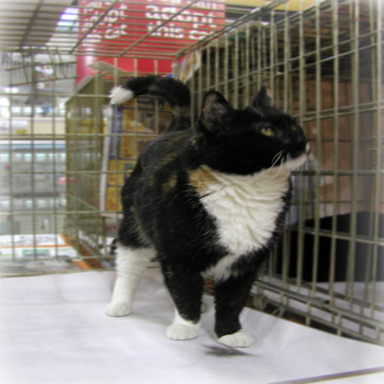

In [96]:
image_resized

In [146]:
grayscales[0].max()

254

In [159]:
model.vit.encoder.layer[-1]

ViTLayer(
  (attention): ViTAttention(
    (attention): ViTSelfAttention(
      (query): Linear(in_features=1024, out_features=1024, bias=True)
      (key): Linear(in_features=1024, out_features=1024, bias=True)
      (value): Linear(in_features=1024, out_features=1024, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (output): ViTSelfOutput(
      (dense): Linear(in_features=1024, out_features=1024, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (intermediate): ViTIntermediate(
    (dense): Linear(in_features=1024, out_features=4096, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): ViTOutput(
    (dense): Linear(in_features=4096, out_features=1024, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (layernorm_before): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
  (layernorm_after): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
)